In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import numpy as np
import cv2 as cv
import mediapipe as mp
import numpy as np
from keras.utils import to_categorical

Import the data and labels, then split into training and testing.

Note that there are many different files here, this is because I processed each video separately, then saved the data in individual files, I combine them all and shuffle them below. (Probably should improve this at some point).

In [2]:
i = 1
X = []
y = []
while True:
    data = f'C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 3\\Classification\\Training Data\\Data{i}.npy'
    labels = f'C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 3\\Classification\\Training Data\\Labels{i}.npy'
    try:
        X.append(np.load(data))
        y.append(np.load(labels))
        i += 1
    except FileNotFoundError:
        print("No more files found. Exiting loop.", i-1)
        break

#Convert to numpy arrays
X = np.concatenate(X)
y = np.concatenate(y)
#Now shuffle all data and labels
perm = np.random.permutation(X.shape[0])
X = X[perm].reshape(X.shape[0],19,1)
y = y[perm]

No more files found. Exiting loop. 26


In [3]:
X.shape,y.shape

((6888, 19, 1), (6888, 3))

In [4]:
model_gru = Sequential()
model_gru.add(GRU(40, return_sequences=True))
model_gru.add(GRU(20,return_sequences=True))
model_gru.add(GRU(15))
model_gru.add(Dense(3, activation='softmax'))

In [5]:
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_gru.fit(X,y, epochs=100, batch_size=20)

Epoch 1/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5717 - loss: 0.8689
Epoch 2/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9125 - loss: 0.2199
Epoch 3/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9271 - loss: 0.1832
Epoch 4/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9280 - loss: 0.1751
Epoch 5/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9195 - loss: 0.1912
Epoch 6/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9291 - loss: 0.1742
Epoch 7/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9302 - loss: 0.1724
Epoch 8/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9297 - loss: 0.1690
Epoch 9/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9213 - loss: 0.1765
Epoch 10/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9252 - loss: 0.1781
Epoch 11/100
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9301 - loss: 0.1737
Epoch 12/100
345/345 ━━━━━━━━━━━━━━━━━━━━

In [6]:
model_gru.save("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 3\\Classification\\Models\\Final Model.h5")

In [11]:
import cv2 as cv
import mediapipe as mp
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

In [12]:
import sys
sys.path.append("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Functions")
from Functions_Squat import height_ratio, moving_average

In [13]:
path = "C:\\Users\\Cian\\Downloads\\Squat Vids\\1 (22).mp4"
X = height_ratio(path)

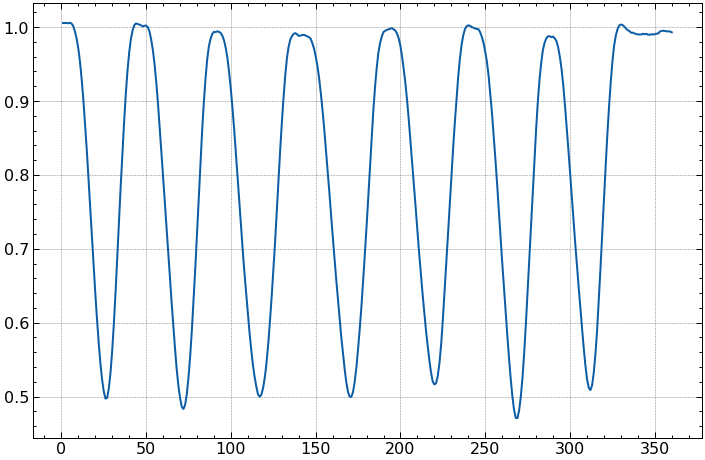

In [14]:
frame_num = np.arange(1,len(X)+1,1)
plt.figure(figsize=(12,8))
plt.plot(frame_num,X)

In [15]:
window = 19
sequences = np.zeros((X.shape[0]-window+1, window))
for i in range(window,X.shape[0]+1):
    sequences[i-window] = X[i-window:i]
    
sequences = sequences.reshape(-1,window,1)

In [16]:
res = model_gru.predict(sequences)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [25]:
#First find the indexes that the class changes, this will allow me to find the class chunks (mentioned above)
choice = to_categorical(np.argmax(res,axis=1),3)
change = choice[1:]*choice[:-1]
C = np.where(np.sum((change == np.array([0,0,0])), axis=1) == 3)[0]
class_chunk = [np.argmax(res[i]) for i in C-1]
        
(C+9)/15,class_chunk

(array([ 0.6       ,  1.6       ,  2.66666667,  3.53333333,  4.66666667,
         5.73333333,  6.46666667,  7.66666667,  8.86666667, 10.        ,
        11.26666667, 12.46666667, 13.33333333, 14.53333333, 15.66666667,
        16.66666667, 17.73333333, 18.86666667, 19.53333333, 20.66666667,
        21.73333333]),
 [0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1])

In [22]:
res_avg = np.copy(res)
Window_Size = 7
res_avg[:,0],res_avg[:,1],res_avg[:,2]= moving_average(res[:,0],Window_Size),moving_average(res[:,1],Window_Size),moving_average(res[:,2],Window_Size)

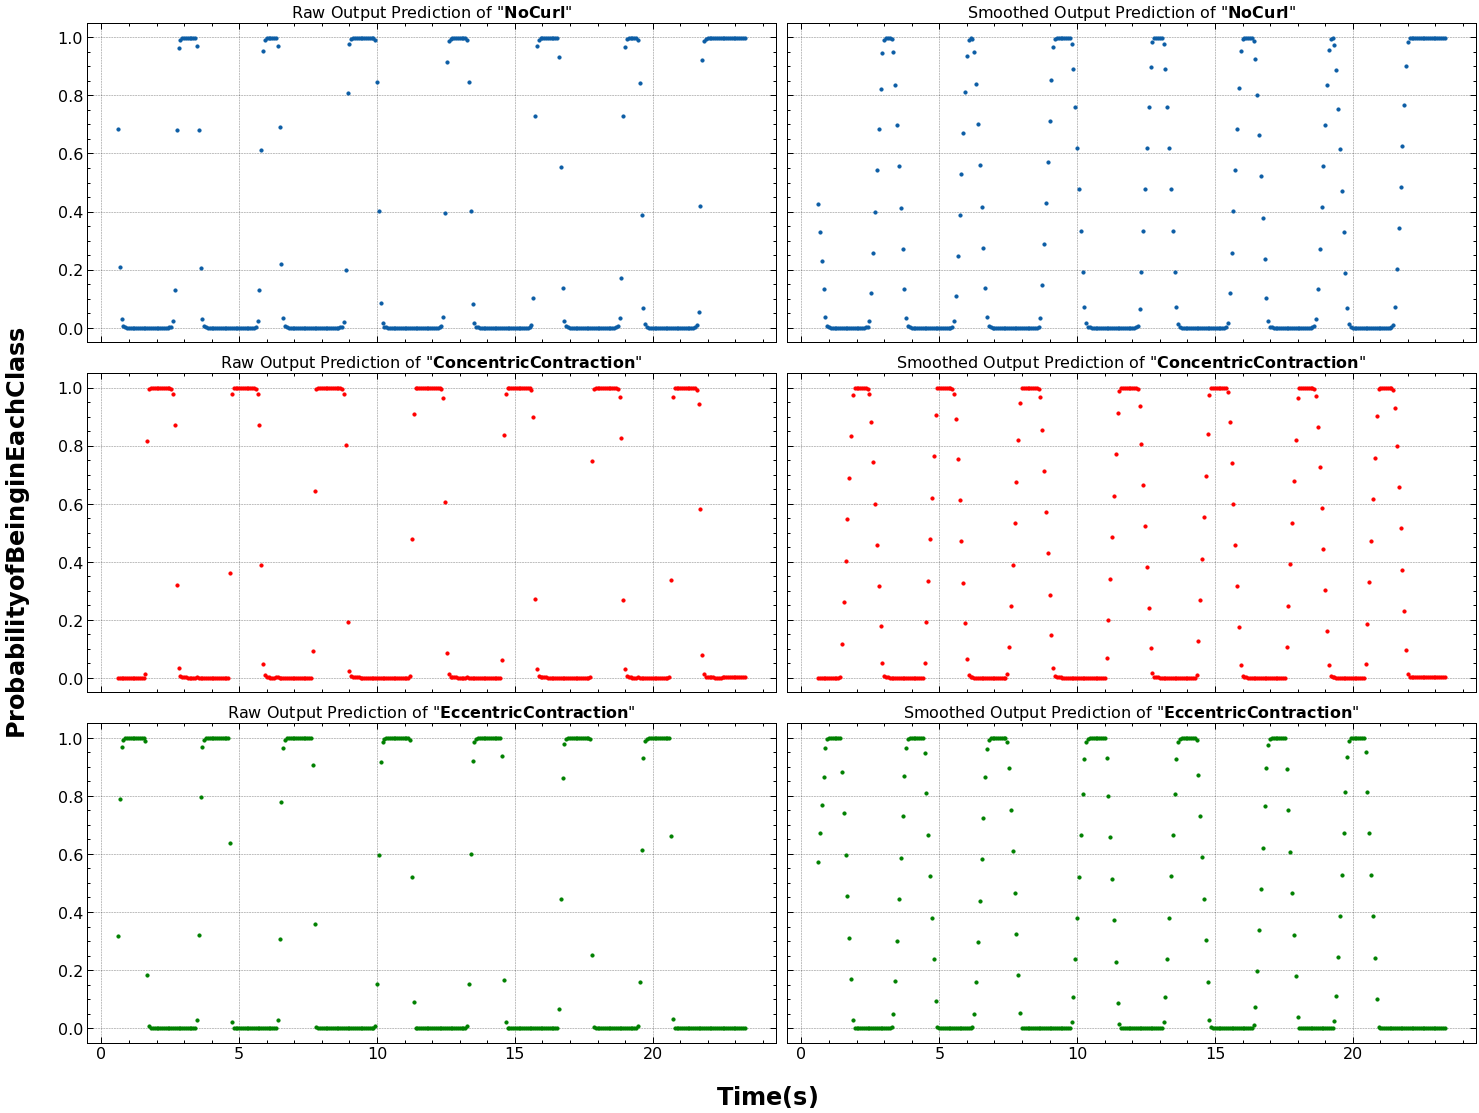

In [24]:
plt.style.use(['science', 'notebook', 'grid'])
t = (np.arange(0,len(res),1)+9)/15

fig, axs = plt.subplots(3, 2, figsize=(20, 15), sharey=True, sharex=True)
axs[0, 1].scatter(t, res_avg[:,0], s=10)
axs[0, 0].scatter(t, res[:,0], s=10)
axs[1, 1].scatter(t, res_avg[:,1], s=10,c='red')
axs[1, 0].scatter(t, res[:,1], s=10,c='red')
axs[2, 1].scatter(t, res_avg[:,2], s=10,c='green')
axs[2, 0].scatter(t, res[:,2], s=10,c='green')

axs[0,0].set_title(r'Raw Output Prediction of "$\bf{No Curl}$"')
axs[0,1].set_title(r'Smoothed Output Prediction of "$\bf{No Curl}$"')
axs[1,0].set_title(r'Raw Output Prediction of "$\bf{Concentric Contraction}$"')
axs[1,1].set_title(r'Smoothed Output Prediction of "$\bf{Concentric Contraction}$"')
axs[2,0].set_title(r'Raw Output Prediction of "$\bf{Eccentric Contraction}$"')
axs[2,1].set_title(r'Smoothed Output Prediction of "$\bf{Eccentric Contraction}$"')

fig.text(-0.03, 0.5, r'$\bf{Probability of Being in Each Class}$', va='center', rotation='vertical', fontsize=24)
fig.text(0.5, -0.03, r'$\bf{Time (s)}$', ha='center', fontsize=24)
plt.tight_layout()
plt.savefig('C:\\Users\\Cian\\Downloads\\FIG.png')

In [14]:
import numpy as np
d = np.zeros((2,3,5))
d[:,:,0] = np.array([[1,2,3]])

array([[[1., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0.]]])